<a href="https://colab.research.google.com/github/jwalx/Tensorflow/blob/main/05_Transfer_Learning_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with TensorFlow Part 2: Fine-Tuning

In [1]:
# Check if we're using a gpu
!nvidia-smi

Fri Jan 27 07:30:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it a good idea to put functions you'll wnat to use aggaian in a script so you can import into it into yur notebook

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-27 07:30:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-27 07:30:53 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback,unzip_data,plot_loss_curves,walk_through_dir

## Lets get some data

This time we're goinf to see how we can use the pretrained models within **tf.keras.applications** and apply them to our own problems


In [4]:
# get 10% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-27 07:30:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.251.16.128, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   253MB/s    in 0.6s    

2023-01-27 07:30:57 (253 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# check how many images and sub directories are there in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
# creating training and test directory 
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

In [7]:
#setting up the input
import tensorflow as tf

IMG_SIZE=(224,224)

train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=32)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode="categorical",
                                                              batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
#see an example of batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[0.00000000e+00 4.87244892e+00 0.00000000e+00]
   [1.00000000e+00 6.00000000e+00 0.00000000e+00]
   [2.14285851e-01 5.21428585e+00 0.00000000e+00]
   ...
   [1.51214325e+02 1.42642853e+02 7.30000687e+01]
   [1.48454102e+02 1.39454102e+02 7.44541016e+01]
   [1.47357040e+02 1.37357040e+02 7.53570404e+01]]

  [[0.00000000e+00 4.57142830e+00 0.00000000e+00]
   [0.00000000e+00 5.00000000e+00 0.00000000e+00]
   [0.00000000e+00 4.21428585e+00 0.00000000e+00]
   ...
   [1.49729614e+02 1.41158142e+02 7.15153503e+01]
   [1.49061249e+02 1.40061249e+02 7.50612488e+01]
   [1.50096878e+02 1.40096878e+02 7.80968704e+01]]

  [[5.05101979e-01 2.85714293e+00 0.00000000e+00]
   [1.57142830e+00 4.21428585e+00 0.00000000e+00]
   [9.54081595e-01 3.42857170e+00 0.00000000e+00]
   ...
   [1.46979553e+02 1.39642807e+02 6.93826599e+01]
   [1.48729584e+02 1.39729584e+02 7.47295837e+01]
   [1.47642822e+02 1.37642822e+02 7.56428223e+01]]

  ...

  [[4.15254707e+01 6.99540634e+01 4.67397652e+01]
   [4

# Model 0 : Building a transfer learning model using keras Functional API
The sequential API is straight-forward,it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.


In [11]:
# 1.Create a base model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# 2.Freeze the base model
base_model.trainable=False

# 3.Create input into model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4.If using model like ResNet50V2 you will need to normalize inputs(not when using EfficientNet)
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5.Pass the inputs to the base_model
x=base_model(inputs)
print(f"shape after passing inputs:{x.shape}")

# 6.Average pool outputsof the model(aggregate all the most important information, reduce the number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after global_average_2D:{x.shape}")

# 7. Create the output activation layer
outputs= tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8.Combine the inputs and outputs into model
model_0=tf.keras.Model(inputs,outputs)

# 9.Compiling the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10.Fit the model and save its history
history_1=model_0.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                             experiment_name="10_percent_feature_extraction")]
                      )

16705208/16705208 [==============================] - 0s 0us/step
shape after passing inputs:(None, 7, 7, 1280)
shape after global_average_2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230127-073105
Epoch 1/5
24/24 [==============================] - 24s 253ms/step - loss: 1.8911 - accuracy: 0.4093 - val_loss: 1.3604 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 5s 184ms/step - loss: 1.1078 - accuracy: 0.7840 - val_loss: 0.8786 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 5s 181ms/step - loss: 0.7882 - accuracy: 0.8360 - val_loss: 0.7088 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 4s 147ms/step - loss: 0.6404 - accuracy: 0.8693 - val_loss: 0.6054 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 4s 145ms/step - loss: 0.5430 - accuracy: 0.8813 - val_loss: 0.5253 - val_accuracy: 0.8734


In [12]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.5575 - accuracy: 0.8600


[0.557516872882843, 0.8600000143051147]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


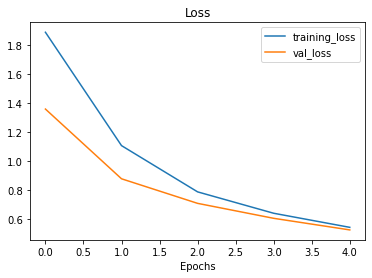

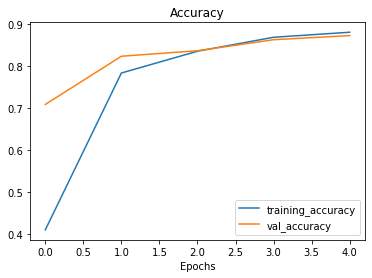

In [16]:
plot_loss_curves(history_1)

# Getting a feature vector from a trained model
Let's demonstrate the Global Average Pooling 2D layer..
We have a tensor after our model goes through `base_model` of shape(None,7,7,1280).
But then when it passes through globalAveragePooling2D, it turns into(None,1280).
Let's use a similiar shaped tensor of(1,4,4,3) and pass it to GlobalAveragePooling2D.
 

In [17]:
# Define the input shape 
input_shape = (1,4,4,3)

# Create a random tensor
input_tensor=tf.random.normal(input_shape)
print(f"random input tensor:\n{input_tensor}\n")
print(f"shape of random tensor:\n{input_tensor.shape}\n")

#passing it to globalaveragepooling2D layer

global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"after passing it becomes:\n{global_average_pooled_tensor}\n")
print(f"shape of global tensor:\n{global_average_pooled_tensor.shape}\n")

random input tensor:
[[[[ 0.49030304  1.578137    0.50825566]
   [ 1.8797406   2.048169   -0.89189065]
   [-0.7371397   0.9098299  -0.40543017]
   [ 1.8107653  -0.8670995  -0.8260749 ]]

  [[ 0.4976899  -0.06825776  1.2524546 ]
   [-1.1339749  -0.45390975  0.36379087]
   [ 1.20249     0.3775119  -1.6482952 ]
   [-1.1963614  -0.85364217  0.12086846]]

  [[ 0.5905132   0.41460136 -1.3870866 ]
   [-0.5626283  -0.37637427 -0.4293392 ]
   [ 1.9306426  -0.38343942 -0.98883384]
   [-0.03342221  0.7589544   0.4246359 ]]

  [[ 0.9119647   0.9841789  -1.0091362 ]
   [-0.1223878   0.5994348  -1.9047226 ]
   [-0.37274465 -1.1407715   0.40446872]
   [-0.6510587   0.83432317  0.74654853]]]]

shape of random tensor:
(1, 4, 4, 3)

after passing it becomes:
[[ 0.28152448  0.2726029  -0.35436165]]

shape of global tensor:
(1, 3)



In [18]:
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.28152448,  0.2726029 , -0.35436165]], dtype=float32)>

In [19]:
#Practicing using globalMaxPool2d
global_max_pooled_tensor=tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"global max pool tensor:\n{global_max_pooled_tensor}\n")
print(f"shape of max pool tensor:\n{global_max_pooled_tensor.shape}\n")

global max pool tensor:
[[1.9306426 2.048169  1.2524546]]

shape of max pool tensor:
(1, 3)



# Running a series of transfer learning experiments

We've seen the incredible results for transfer learning can get with only 10% of training data ,but how does it perform on 1% percent of training ... how about we set up a bunch of experiments to find out:


In [20]:
#download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

train_dir_1_percent="10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test"


--2023-01-27 07:32:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   182MB/s    in 0.7s    

2023-01-27 07:32:06 (182 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [22]:
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         batch_size=32,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             label_mode="categorical",
                                                             image_size=IMG_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Implementing data augmentation in form of layer using `keras.layers` and `keras.experimental.preprocessing`

In [23]:
import tensorflow as tf
from tensorflow import keras

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = tf.keras.Sequential(
[
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

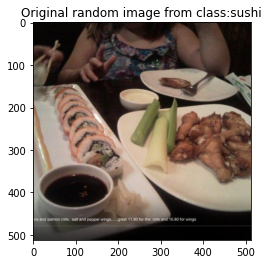

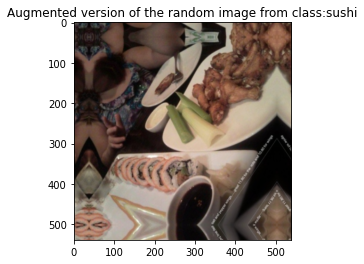

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random
target_class=random.choice(train_data_1_percent.class_names)  #choosing random image
target_dir  ="10_food_classes_1_percent/train/"+target_class #create the target directory
random_image =random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class:{target_class}")
plt.axis==False;

# augment the image
augmented_img=data_augmentation(img ,training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented version of the random image from class:{target_class}")
plt.axis==False;

## `Model 1`: Feature extraction of 1% of training data 

In [25]:
# setting up Input shape, base model and freezing base model layers
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# input layer
inputs =tf.keras.layers.Input(shape=input_shape,name="input_layer")

# adding data augmentation
x=data_augmentation(inputs,training=True)

# give base model inputs and dont train it
x=base_model(x,training=False) 

# pool the outputs of the base model
x=tf.keras.layers.GlobalAveragePooling2D(name="global_pooling_layer")(x)

# Put dense layer on as output
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

model_1=keras.Model(inputs,outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1_percent=model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=0.25*(len(test_data)),
                              #tracking model
                              callbacks=[create_tensorboard_callback("transfer_learning","1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230127-073210
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.3828 - accuracy: 0.1000

3/3 [==============================] - 20s 7s/step - loss: 2.3828 - accuracy: 0.1000 - val_loss: 2.2789 - val_accuracy: 0.1719
Epoch 2/5
3/3 [==============================] - 8s 4s/step - loss: 2.1376 - accuracy: 0.2571 - val_loss: 2.1681 - val_accuracy: 0.2078
Epoch 3/5
3/3 [==============================] - 8s 4s/step - loss: 1.8555 - accuracy: 0.4571 - val_loss: 2.0551 - val_accuracy: 0.3078
Epoch 4/5
3/3 [==============================] - 8s 4s/step - loss: 1.7742 - accuracy: 0.5286 - val_loss: 1.9725 - val_accuracy: 0.3406
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5855 - accuracy: 0.7143 - val_loss: 1.8797 - val_accuracy: 0.4016


In [26]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pooling_layer (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
model_1.evaluate(test_data)

79/79 [==============================] - 21s 263ms/step - loss: 1.8846 - accuracy: 0.4008


[1.8845845460891724, 0.4007999897003174]

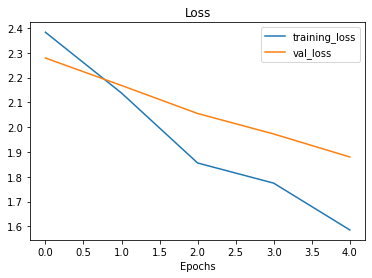

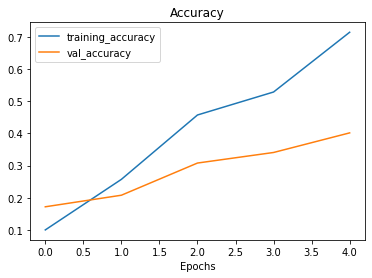

In [28]:
plot_loss_curves(history_1_percent)

## Model 2 : Feature extraction transfer learning mode with 10%

Since we have already downloaded and unzipped 10 percent data so no need to do it again


In [29]:
train_dir_10_percent="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"



In [30]:
#set data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#creating model 2 with data augmentation
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation =Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
],name="data_augmentation")


#Setup the input shape to our model
input_shape=(224,224,3)

# Create a frozen base layer(also called backbone)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#create inputs and outputs
inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(inputs,training=True)
x=base_model(x,training=False)
x= layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2=tf.keras.Model(inputs,outputs)

#compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Creating a modelcheckpoint callback

the modelcheckpoint callback intermediately saves our model (full model or just the weights) during training. This is usefull so we can come and start from where we left

In [33]:
# set checkpoint path
checkpointpath="ten_percent_model_checkpoints_weights/chekpoint.ckpt"

# create a modelcheckpoint callback that saves the model's weights only 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointpath,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)


In [34]:
# Fit model 2 passing in the modelcheckpoint callback
initial_epochs = 5
history_model_2=model_2.fit(train_data_10_percent,
                            epochs=initial_epochs,
                            validation_data=test_data,
                            validation_steps=0.25*(len(test_data)),
                            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                  experiment_name="10_percent_model_2"),
                                      checkpoint_callback])                                     

Saving TensorBoard log files to: transfer_learning/10_percent_model_2/20230127-073339
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9726 - accuracy: 0.3560
Epoch 1: saving model to ten_percent_model_checkpoints_weights/chekpoint.ckpt
24/24 [==============================] - 26s 843ms/step - loss: 1.9726 - accuracy: 0.3560 - val_loss: 1.5012 - val_accuracy: 0.6469
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2997 - accuracy: 0.7040
Epoch 2: saving model to ten_percent_model_checkpoints_weights/chekpoint.ckpt
24/24 [==============================] - 11s 470ms/step - loss: 1.2997 - accuracy: 0.7040 - val_loss: 1.0906 - val_accuracy: 0.7484
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.7653
Epoch 3: saving model to ten_percent_model_checkpoints_weights/chekpoint.ckpt
24/24 [==============================] - 12s 481ms/step - loss: 1.0079 - accuracy: 0.7653 - val_loss: 0.9121 - val_accuracy: 0.7875
Epoch

In [35]:
# model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.5575 - accuracy: 0.8600


[0.5575168132781982, 0.8600000143051147]

In [36]:
# model_2 results
results_10_percent_data_aug=model_2.evaluate(test_data)

79/79 [==============================] - 18s 225ms/step - loss: 0.7658 - accuracy: 0.8004


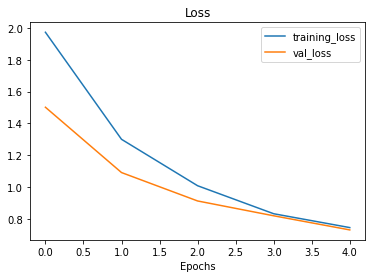

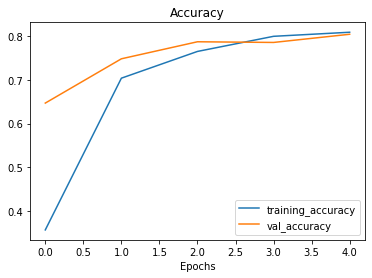

In [37]:
plot_loss_curves(history_model_2)

# loading in checkpoints weights
Loading in checkpointed weights returns a mdoel to a specific checkpoint

In [38]:
#load in the saved model weights and evaluate model
model_2.load_weights(checkpointpath)


In [39]:
# evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 17s 213ms/step - loss: 0.7552 - accuracy: 0.8056


In [40]:
# if the results from our previously evaluated model_2 match the loaded weights,
results_10_percent_data_aug==loaded_weights_model_results

False

In [41]:
results_10_percent_data_aug

[0.7657696008682251, 0.8004000186920166]

In [42]:
loaded_weights_model_results

[0.755186915397644, 0.8055999875068665]

## Our first fine tuned model:Model 3
Fine tuning with existing 1% data


In [43]:
model_2.layers

In [44]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f6a076caa30> True
<keras.engine.sequential.Sequential object at 0x7f6a076ca7f0> True
<keras.engine.functional.Functional object at 0x7f6a04e78820> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f6a076c1b80> True
<keras.layers.core.dense.Dense object at 0x7f6a076caa00> True


In [45]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [46]:
# How many trainable vairable are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [47]:
# to begin fine-tuning lets start by settling last 10 layers of our base_model.trainable=True
base_model.trainable=True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

#Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), #when  fine-tuning we typrically want to lower the lr
                metrics=["accuracy"])


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
#check the number of tunable(trainable) layers
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [49]:
# Now that we have unfrozen some of the laeyrs claoser to the top how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [50]:
# fine tune fro another 5 epochs
fine_tune_epochs=initial_epochs+5

# Refit the model(same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             validation_steps=int(0.25* len(test_data)),
                                             initial_epoch=history_model_2.epoch[-1], # start training from previous last epoch
                                             callbacks=create_tensorboard_callback(dir_name="transfer_learning",
                                                                                   experiment_name="10_percent_fine_tune_last_epoch"))

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_epoch/20230127-073547
Epoch 5/10
24/24 [==============================] - 20s 571ms/step - loss: 0.6204 - accuracy: 0.8347 - val_loss: 0.6072 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 11s 464ms/step - loss: 0.5223 - accuracy: 0.8560 - val_loss: 0.5525 - val_accuracy: 0.8224
Epoch 7/10
24/24 [==============================] - 11s 441ms/step - loss: 0.4244 - accuracy: 0.8773 - val_loss: 0.5437 - val_accuracy: 0.8240
Epoch 8/10
24/24 [==============================] - 9s 357ms/step - loss: 0.4148 - accuracy: 0.8760 - val_loss: 0.5324 - val_accuracy: 0.8059
Epoch 9/10
24/24 [==============================] - 9s 362ms/step - loss: 0.3631 - accuracy: 0.8960 - val_loss: 0.5568 - val_accuracy: 0.8257
Epoch 10/10
24/24 [==============================] - 10s 406ms/step - loss: 0.3323 - accuracy: 0.8933 - val_loss: 0.5736 - val_accuracy: 0.8141


In [51]:
#evaluate fine tuned model_2 which is model_3
results_fine_tuned_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 16s 195ms/step - loss: 0.5452 - accuracy: 0.8144


In [52]:
results_fine_tuned_10_percent

[0.545217752456665, 0.8144000172615051]

In [53]:
results_10_percent_data_aug

[0.7657696008682251, 0.8004000186920166]

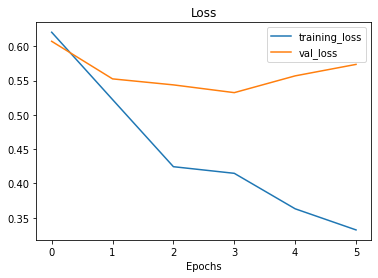

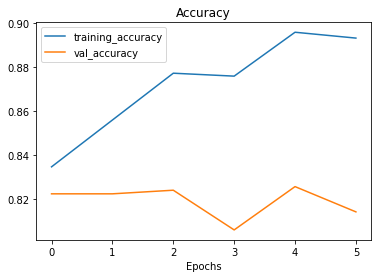

In [54]:
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however we want the running of `fit()` with another(eg:before and after fine-tuning)

In [55]:
# Create a function to compare training histories
def compare_history(original_history,new_history,initial_epochs=5):
  """
  Compares two Tensorflow History objects.
  """
  #get original history measurements
  acc=original_history.history["accuracy"]
  loss=original_history.history["loss"]

  val_acc= original_history.history["val_accuracy"]
  val_loss=original_history.history["val_loss"]

  #combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="training accuracy")
  plt.plot(total_val_acc,label="val accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start fine tuning")
  plt.legend(loc="lower right")
  plt.title("training and Validation accuracy")

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="training loss")
  plt.plot(total_val_loss,label="val loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="start fine tuning")
  plt.legend(loc="lower right")
  plt.title("training and val loss")

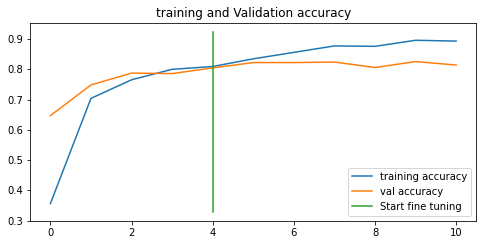

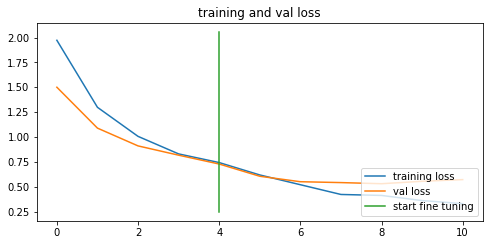

In [56]:
compare_history(history_model_2,
                history_fine_10_percent_data_aug,
                initial_epochs=5)

## Model 4 : on 100% data

In [57]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-01-27 07:37:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.251.16.128, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   129MB/s    in 4.0s    

2023-01-27 07:37:25 (124 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [58]:
#setup training and test dir
train_dir_all_data="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [59]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [60]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [61]:
#evaluate model 2(this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 15s 179ms/step - loss: 0.5613 - accuracy: 0.8180


[0.5613342523574829, 0.8180000185966492]

In [62]:
results_fine_tuned_10_percent

[0.545217752456665, 0.8144000172615051]

To train a Fine-tuning (model_4) we need to revert model_2 back to its feature extraction weights.


In [63]:
# load weights from checkpoint,what way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpointpath)

In [64]:
# lets evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 15s 187ms/step - loss: 0.7650 - accuracy: 0.7992


[0.7649610638618469, 0.7991999983787537]

## Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained feauture extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weight using `ModelCheckpoint` callback.
2. Fine-Tuning the same model on the same 10% of the data for a further 5 epochs with top 10 layers of the base model unfrozen(model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to the same steps as step 2 except this time we're going to use all of the data(model_4).

In [65]:
# lets check which layers are tunable in the whole model
for layer_number,layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling True
4 output_layer True


In [66]:
# lets drill into our base model
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [67]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=("accuracy"))


In [68]:
# Continue to train and fine-tune the model to our data(100% of training data)
fine_tune_epochs=initial_epochs+5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_dir)),
                                           initial_epoch=history_model_2.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230127-073801
Epoch 5/10
235/235 [==============================] - 55s 205ms/step - loss: 0.6510 - accuracy: 0.7951 - val_loss: 0.4379 - val_accuracy: 0.8438
Epoch 6/10
235/235 [==============================] - 42s 178ms/step - loss: 0.5226 - accuracy: 0.8305 - val_loss: 0.3800 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 43s 179ms/step - loss: 0.4696 - accuracy: 0.8473 - val_loss: 0.3420 - val_accuracy: 0.8973
Epoch 8/10
235/235 [==============================] - 39s 164ms/step - loss: 0.4219 - accuracy: 0.8628 - val_loss: 0.3775 - val_accuracy: 0.8705
Epoch 9/10
235/235 [==============================] - 37s 158ms/step - loss: 0.3873 - accuracy: 0.8737 - val_loss: 0.2825 - val_accuracy: 0.8973
Epoch 10/10
235/235 [==============================] - 39s 165ms/step - loss: 0.3557 - accuracy: 0.8805 - val_loss: 0.3731 - val_accuracy: 0.8839


In [69]:
# Evaluate on all data
model_2.evaluate(test_data)

79/79 [==============================] - 13s 161ms/step - loss: 0.3371 - accuracy: 0.8852


[0.33710169792175293, 0.885200023651123]

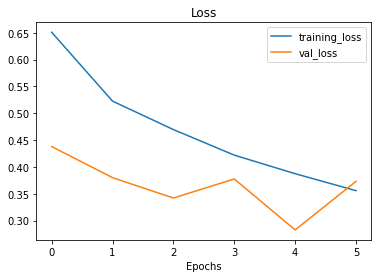

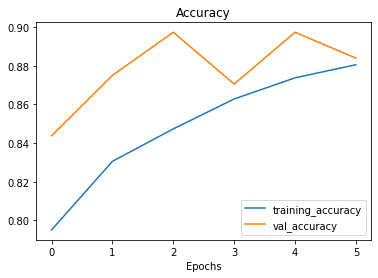

In [70]:
plot_loss_curves(history_fine_10_classes_full)

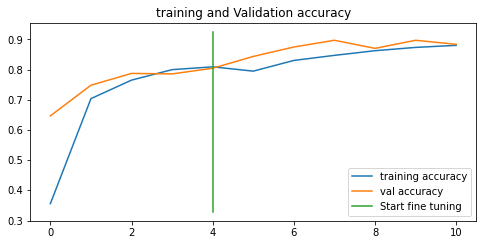

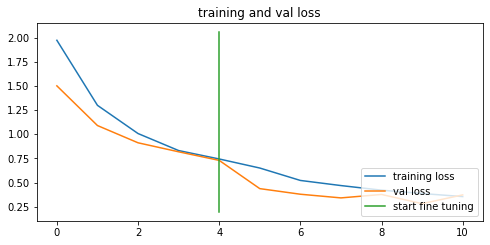

In [71]:
# how did fine tuning go with more data
compare_history(original_history=history_model_2,
                new_history=history_fine_10_classes_full)

 # Viewing our experiment data on TensorBoard

In [74]:
# view tensorboard logs of transfer learning modelling experiments 
# upload tesnorboard dev records
!tensYorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes"\
  --description "A series of transfer learning experiments"\
  --one_shot # Exits the uploader once done


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=AlP42so99TxqkITljT4i2gwwyOc9nJ&prompt=consent&access_type=o

# My tensorboard experiments are available on this site:https://tensorboard.dev/experiment/Vs3x2UoAT7SmywPndlwZZQ/ 